1. Install Apache Beam and Necessary Packages

In [1]:
!pip install apache-beam[gcp] beam-nuggets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.7 MB/s eta 

In [2]:
!pip install transformers --quiet

2. Import Libraries for Apache Beam

In [3]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

Sample data

In [4]:
# sample data for a logistics use case
sample_data = [
    {'shipment_id': 'S2001', 'item': 'Electronics', 'weight_kg': 12, 'distance_km': 150},
    {'shipment_id': 'S2002', 'item': 'Furniture', 'weight_kg': 50, 'distance_km': 80},
    {'shipment_id': 'S2003', 'item': 'Books', 'weight_kg': 5, 'distance_km': 200},
    {'shipment_id': 'S2004', 'item': 'Clothing', 'weight_kg': 8, 'distance_km': 120},
    {'shipment_id': 'S2005', 'item': 'Appliances', 'weight_kg': 30, 'distance_km': 50}
]

4. Composite Transform Example

In [5]:
# Create a custom composite transform to calculate shipment cost
class CalculateShipmentCost(beam.PTransform):
    def expand(self, pcoll):
        return (pcoll
                | "Calculate Cost" >> beam.Map(lambda x: {
                    **x, 'cost': x['weight_kg'] * 0.5 + x['distance_km'] * 0.2
                }))

# Use the composite transform in a pipeline
with beam.Pipeline() as pipeline:
    results = (pipeline
               | "Create Sample Data" >> beam.Create(sample_data)
               | "Apply Composite Transform" >> CalculateShipmentCost()
               | "Print Results" >> beam.Map(print))

{'shipment_id': 'S2001', 'item': 'Electronics', 'weight_kg': 12, 'distance_km': 150, 'cost': 36.0}
{'shipment_id': 'S2002', 'item': 'Furniture', 'weight_kg': 50, 'distance_km': 80, 'cost': 41.0}
{'shipment_id': 'S2003', 'item': 'Books', 'weight_kg': 5, 'distance_km': 200, 'cost': 42.5}
{'shipment_id': 'S2004', 'item': 'Clothing', 'weight_kg': 8, 'distance_km': 120, 'cost': 28.0}
{'shipment_id': 'S2005', 'item': 'Appliances', 'weight_kg': 30, 'distance_km': 50, 'cost': 25.0}


5. Reading and Writing Data (Pipeline I/O)

In [6]:
# Example of reading from and writing to a file
input_file = 'shipments_input.txt'
output_file = 'shipments_output.txt'

# Writing sample data to the input file for demonstration
with open(input_file, 'w') as file:
    for data in sample_data:
        file.write(str(data) + '\n')

with beam.Pipeline() as pipeline:
    data = (pipeline
            | "Read from File" >> beam.io.ReadFromText(input_file)
            | "Transform Data" >> beam.Map(lambda x: x.lower())  # Dummy transformation
            | "Write to File" >> beam.io.WriteToText(output_file))


below i have attached the image that depicts that the file have been created using the reading and writing the to file code.

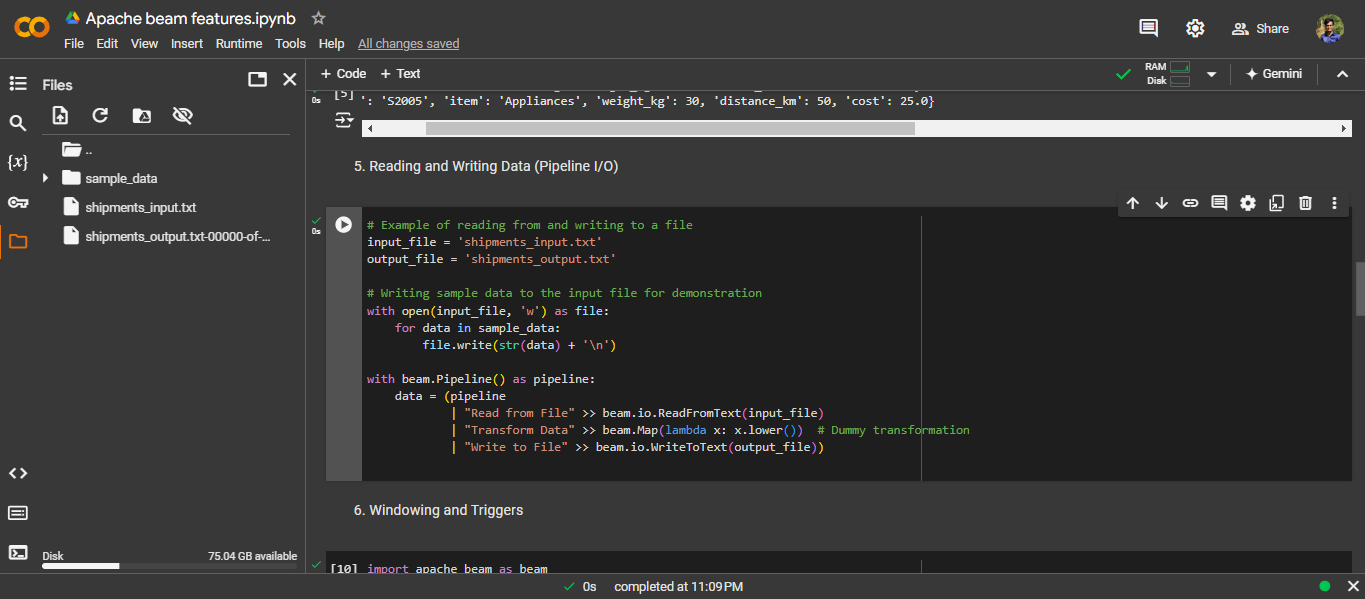

6. Windowing and Triggers

In [10]:
import apache_beam as beam
from apache_beam.transforms.window import FixedWindows
from apache_beam.transforms.trigger import AfterProcessingTime, AccumulationMode, DefaultTrigger

# Demonstrate windowing with fixed intervals for simulated shipment updates
with beam.Pipeline() as pipeline:
    windowed_data = (pipeline
                     | "Generate Shipment Updates" >> beam.Create([100, 200, 300, 400, 500])
                     | "Apply Fixed Windowing" >> beam.WindowInto(
                         FixedWindows(10),  # 10-second fixed windows
                         trigger=AfterProcessingTime(delay=5),  # 5-second delay after processing
                         accumulation_mode=AccumulationMode.DISCARDING,
                         allowed_lateness=0  # Specify allowed lateness if needed
                     )
                     | "Print Windowed Data" >> beam.Map(print))

100
200
300
400
500


7. Using ParDo for Parallel Processing

In [11]:
class ExtractShipmentDetails(beam.DoFn):
    def process(self, element):
        details = element.split()
        yield f"Shipment: {details[0]}, Details: {details[1:]}"

# Demonstrate ParDo with the sample shipment data
with beam.Pipeline() as pipeline:
    shipment_details = (pipeline
                        | "Create Shipment Text" >> beam.Create([
                            "S2001 Electronics 12kg 150km",
                            "S2002 Furniture 50kg 80km"
                        ])
                        | "Extract Details with ParDo" >> beam.ParDo(ExtractShipmentDetails())
                        | "Print Shipment Details" >> beam.Map(print))


Shipment: S2001, Details: ['Electronics', '12kg', '150km']
Shipment: S2002, Details: ['Furniture', '50kg', '80km']


8. Streaming Example (Conceptual)

In [15]:
import apache_beam as beam
import time

# Simulate streaming data with Apache Beam
class GenerateStream(beam.DoFn):
    def process(self, element):
        # Simulate real-time streaming by delaying the output
        time.sleep(1)  # Delay to mimic streaming (1 second between elements)
        yield element

# Define the Apache Beam pipeline
with beam.Pipeline() as pipeline:
    stream_data = (pipeline
                   | "Generate Simulated Data" >> beam.Create([100, 200, 300, 400, 500])
                   | "Simulate Streaming with Delay" >> beam.ParDo(GenerateStream())
                   | "Process Streamed Data" >> beam.Map(lambda x: f"Processed: {x}")
                   | "Output Data" >> beam.Map(print))


Processed: 100
Processed: 200
Processed: 300
Processed: 400
Processed: 500


In [17]:
# Class to simulate streaming data
class SimulateStream(beam.DoFn):
    def process(self, element):
        # Delay to simulate streaming
        time.sleep(1)
        yield element

9. Running Inference with BeamML (Sklearn)

In [18]:
import apache_beam as beam
from sklearn.linear_model import LinearRegression
import numpy as np

# Create a dummy linear regression model
model = LinearRegression()
X_train = np.array([[10], [20], [30], [40]])
y_train = np.array([15, 30, 45, 60])
model.fit(X_train, y_train)

# Custom DoFn for running model inference
class ModelInference(beam.DoFn):
    def process(self, element):
        # Make predictions using the trained model
        prediction = model.predict([element])
        yield f"Input: {element}, Prediction: {prediction[0]}"

# Define the Apache Beam pipeline
with beam.Pipeline() as pipeline:
    inference_results = (pipeline
                         | "Create Test Data" >> beam.Create([[50], [60]])
                         | "Run Model Inference" >> beam.ParDo(ModelInference())
                         | "Print Inference Results" >> beam.Map(print))

Input: [50], Prediction: 75.0
Input: [60], Prediction: 90.0
